# Retinal Blood Vessels Segmentation
### `IABI Course, Dr. Rohban`
#### Homework 1
*`Full Name:`* Saeed Mansourlakouraj

*`SID:`* 99102304

## Proposed Method Description


In this notebook, we aim to extract suitable features using **image processing techniques**,
to obtain a **20-dimensional feature vector** for each pixel. Then, by using a **simple neural network**,
we train the model to learn these features. The goal is for the network to predict, for the **pixels in the test images**,
whether the pixels belong to **vessels** or the **background**.

<p align="left">
<img src="https://drive.usercontent.google.com/download?id=1wpOngGlh_wRui368o22RlfrzPOp7HZKq&export=download&authuser=0&confirm=t&uuid=ccc851a6-589d-47a1-94c5-75343b6e3427&at=AN_67v00Rdv1c_MovmsIyGdovxg6:1727563819162" alt="" width="500"/>
</p>

In [ ]:
!pip install gdown

In [1]:
! gdown 1Z1vEpzO2W4TEQmQU-VhWKBg1-u40LUte
! unzip DRIVE

Downloading...
From (original): https://drive.google.com/uc?id=1Z1vEpzO2W4TEQmQU-VhWKBg1-u40LUte
From (redirected): https://drive.google.com/uc?id=1Z1vEpzO2W4TEQmQU-VhWKBg1-u40LUte&confirm=t&uuid=d8cb0011-5d5d-4cd1-889a-2b24245baee2
To: /content/DRIVE.zip
100% 29.8M/29.8M [00:00<00:00, 34.2MB/s]
Archive:  DRIVE.zip
   creating: DRIVE/Test/
   creating: DRIVE/Test/1st_manual/
 extracting: DRIVE/Test/1st_manual/01_manual1.gif  
 extracting: DRIVE/Test/1st_manual/02_manual1.gif  
 extracting: DRIVE/Test/1st_manual/03_manual1.gif  
 extracting: DRIVE/Test/1st_manual/04_manual1.gif  
 extracting: DRIVE/Test/1st_manual/05_manual1.gif  
 extracting: DRIVE/Test/1st_manual/06_manual1.gif  
 extracting: DRIVE/Test/1st_manual/07_manual1.gif  
 extracting: DRIVE/Test/1st_manual/08_manual1.gif  
 extracting: DRIVE/Test/1st_manual/09_manual1.gif  
 extracting: DRIVE/Test/1st_manual/10_manual1.gif  
 extracting: DRIVE/Test/1st_manual/11_manual1.gif  
 extracting: DRIVE/Test/1st_manual/12_manual1.gif 

In [2]:
import cv2
import imageio
import numpy as np
import pandas as pd
from os import listdir
import scipy.ndimage as ndi
from typing import *
from scipy.stats import kurtosis, skew
import matplotlib.pyplot as plt
from os.path import isfile, join
import skimage.measure
from skimage.morphology import disk
#from google.colab.patches import cv2_imshow
from tqdm import tqdm

In [3]:
def plot_images(images: list[np.ndarray]):
    plt.figure(figsize=(16, 3))
    plt.imshow(
        np.hstack(images), cmap='gray'
    )
    plt.axis('off')
    plt.show()

**DRIVE Dataset Overview:**

In this notebook, the DRIVE dataset has been used, which contains two sets of images: train and test. Each set includes 20 retinal images. For each image, there is a corresponding mask that defines the region of the retina within the image.

The label associated with each image is a binary image where the vessels are represented by the value 255 and the background by the value 0.

Important: Pathological features related to each image are not specified in the dataset.

Note: The labels for the test images are provided by two specialists.

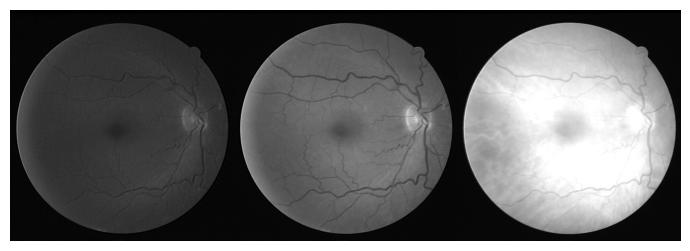

In [4]:
test_img = cv2.imread('DRIVE/Training/images/22_training.tif')
test_mask = np.array(imageio.mimread('DRIVE/Training/mask/22_training_mask.gif')).reshape(584, 565)

plot_images([test_img[:, :, 0], test_img[:, :, 1], test_img[:, :, 2]])

You must select one of the red, green, or blue channels from the color image `(Explain your reasoning for the selection)`.

`Your response (2 pts):` We must select the green channel, because it provides the highest contrast between the blood vessels and the background in fundus images.

## Pre-Process (10 pts)

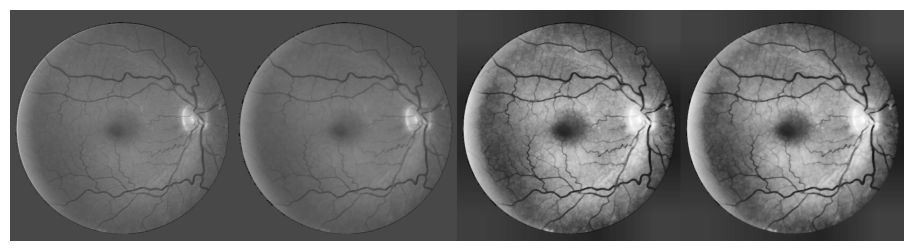

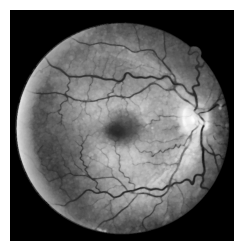

In [5]:
def PreProcess (image: np.ndarray, mask: np.ndarray,plot_image: bool) :
  """
      Args:
          - image (np.ndarray): A 2D  array, shape (height, width).
          - mask (np.ndarray): A binary mask array, shape (height, width).

      Returns:
          - Processed Image (np.ndarray): A 2D array of the same shape as image.

      Steps:
          - Mask Adjustment:
          - Morphological Opening
          - Contrast Enhancement
          - Smoothing


  """
  #################################################################################
  #                         YOUR CODE GOES HERE                                   #

  #first convert mask to binary mask
  index = np.where(mask > 0)
  mask[index] = 1

  #replace zero masks with mean of the masked image
  masked_image = image * mask
  mean = masked_image.mean()
  index = np.where(masked_image == 0)
  image[index] = mean

  SE = disk(2)
  #now perform steps mentioned in document : you can refer to :
  # https://docs.opencv.org/3.4/d9/d61/tutorial_py_morphological_ops.html
  # https://docs.opencv.org/4.x/d6/db6/classcv_1_1CLAHE.html
  # https://docs.opencv.org/4.x/d4/d86/group__imgproc__filter.html#ga564869aa33e58769b4469101aac458f9


  opening = cv2.morphologyEx(image, cv2.MORPH_OPEN, SE)
  clahe = cv2.createCLAHE(clipLimit=4, tileGridSize=(4, 4))
  clh = clahe.apply(opening.astype(np.uint8))
  median = cv2.medianBlur(clh, 3)
  #################################################################################






  if plot_image:
    plot_images([image,opening,clh,median])
  return np.multiply(median, mask)

test_img_preprocessed = PreProcess(test_img[:, :, 1], test_mask, plot_image=True)
plot_images([test_img_preprocessed])


## Feature Extraction (70 pts)

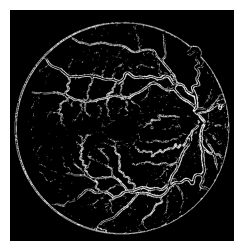

In [6]:
def Roberts_Edge_Detection(image):
    """
    Args:
        image (np.ndarray): A 2D grayscale image array of shape (height, width)


    Returns:
        np.ndarray: A binary image of the same shape as the input image.
    """
    #################################################################################
    #                         YOUR CODE GOES HERE                                   #

    # Roberts Edge Detection: The Roberts operator measures a 2-D spatial gradient on an image in a straightforward, quick-to-compute manner.
    # TODO : Handle Threshold from paper
    image = image.astype('float64')/255.0
    threshold = 0.07
    roberts_cross_v = np.array( [[1, 0 ], [0,-1 ]] )
    roberts_cross_h = np.array( [[ 0, 1 ], [ -1, 0 ]] )

    vertical = ndi.convolve(image, roberts_cross_v)
    horizontal = ndi.convolve(image, roberts_cross_h)
    edged_img_sqrt = np.sqrt(vertical**2 + horizontal**2)
    edged_img = ((edged_img_sqrt / edged_img_sqrt.max()) * 255.0).astype(np.uint8)
    _, edged_img_thersh = cv2.threshold(edged_img, threshold * 255, 255, cv2.THRESH_BINARY )
    #################################################################################
    # I changed this part ( I think it was incorrect)
    return edged_img_thersh
test_edged_img=Roberts_Edge_Detection(test_img_preprocessed)
plot_images([test_edged_img])

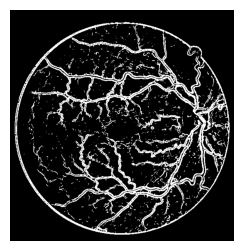

In [7]:
def Prewitt_Edge_Detection(image):
    """
    Args:
        image (np.ndarray): A 2D grayscale image array of shape (height, width)


    Returns:
        np.ndarray: A binary image of the same shape as the input image.
    """
    #################################################################################
    #                         YOUR CODE GOES HERE                                   #

    #Prewitt mask is a first-order derivative mask. In the graph representation of Prewitt-mask’s result, the edge is represented by the local maxima or local minima.
    kernelx = np.array([[-1,0,1],[-1,0,1],[-1,0,1]])
    kernely = np.array([[-1,-1,-1],[0,0,0],[1,1,1]])
    threshold = 0.07
    image = image.astype('float64')/255.0
    img_prewittx = ndi.convolve(image, kernelx)
    img_prewitty = ndi.convolve(image, kernely)
    edged_img_sqrt = np.sqrt(img_prewittx**2 + img_prewitty**2)
    edged_img = ((edged_img_sqrt / edged_img_sqrt.max()) * 255.0).astype(np.uint8)
    _, edged_img = cv2.threshold(edged_img, threshold * 255, 255, cv2.THRESH_BINARY )
    #################################################################################
    return edged_img
test_edged_img=Prewitt_Edge_Detection(test_img_preprocessed)
plot_images([test_edged_img])

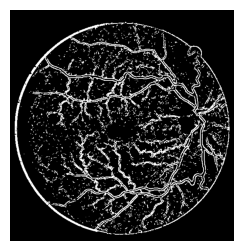

In [8]:
def LOG_Edge_Detection(image):
    """
    Args:
        image (np.ndarray): A 2D grayscale image array of shape (height, width)


    Returns:
        np.ndarray: A binary image of the same shape as the input image.
    """
    #################################################################################
    #                         YOUR CODE GOES HERE                                   #
    blur = cv2.GaussianBlur(image, (3, 3), 0)

    LoG = cv2.Laplacian(blur, cv2.CV_64F)
    kernel = np.ones((3, 3), np.uint8)
    minLoG = cv2.morphologyEx((LoG < -4).astype(np.uint8), cv2.MORPH_DILATE, kernel)
    maxLoG = cv2.morphologyEx((LoG > 4).astype(np.uint8), cv2.MORPH_DILATE, kernel)
    zeroCross = np.zeros_like(LoG, dtype=np.uint8)
    for i in range(1, LoG.shape[0] - 1):
        for j in range(1, LoG.shape[1] - 1):
            neighborhood = LoG[i-1:i+2, j-1:j+2]
            if np.min(neighborhood) < 0 and np.max(neighborhood) > 0:
                zeroCross[i, j] = 255

    zeroCross = cv2.bitwise_and(zeroCross, minLoG)
    zeroCross = cv2.bitwise_and(zeroCross, maxLoG)

    return zeroCross
    #################################################################################
    return zeroCross
test_edged_img=LOG_Edge_Detection(test_img_preprocessed)
plot_images([test_edged_img])

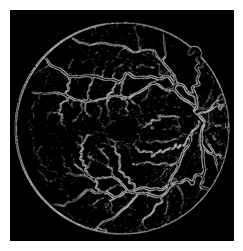

In [9]:
def Edge_Algorithm_features(image):
  # This has some problem L and S
    """
      Extract edge features from a grayscale image using Roberts, Prewitt and LOG edge detection algorithms.

      Args:
          image (np.ndarray): A 2D grayscale image array of shape (height, width)

      Returns:
          np.ndarray: A binary image of the same shape as the input image.
    """
    #################################################################################
    #                         YOUR CODE GOES HERE                                   #
    #Roberts, Prewitt, Sobel, Canny, Log
    R = Roberts_Edge_Detection(image=image)
    P = Prewitt_Edge_Detection(image=image)
    S = cv2.Sobel(image, cv2.CV_64F, 1, 1, ksize=3)
    _, S = cv2.threshold(S, 16, 255, cv2.THRESH_BINARY)
    C = cv2.Canny(image,100, 200)
    L = LOG_Edge_Detection(image)
    #################################################################################
    return S+C+R+P +L
test_edged_img=Edge_Algorithm_features(test_img_preprocessed)
plot_images([test_edged_img])

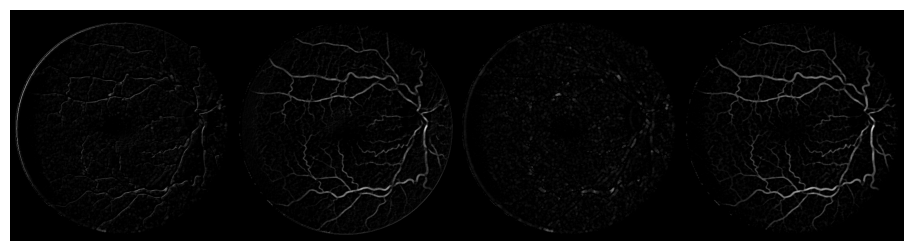

In [10]:
def Morphological_features(image):
    """
      Extract morphological features from a grayscale image using
      top-hat and black-hat morphological transformations.

      Args:
          image (np.ndarray): A 2D grayscale image array of shape (height, width).

      Returns:
          tuple: A tuple containing four elements:
              - tophat_img (np.ndarray): The top-hat transformed image, highlighting
                bright features on a dark background.
              - bothat_img (np.ndarray): The black-hat transformed image, emphasizing
                dark features on a bright background.
              - tophat_img2 (np.ndarray): The second top-hat transformed image with
                a different structuring element orientation.
              - bothat_img2 (np.ndarray): The second black-hat transformed image with
                a different structuring element orientation.

    """
    #################################################################################
    #                         YOUR CODE GOES HERE                                   #
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (6, 6))
    tophat_img = cv2.morphologyEx(image, cv2.MORPH_TOPHAT, kernel)
    bothat_img = cv2.morphologyEx(image, cv2.MORPH_BLACKHAT, kernel)

    ######### new features added #################################
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9))
    tophat_img2 = cv2.morphologyEx(image, cv2.MORPH_TOPHAT, kernel)
    bothat_img2 = cv2.morphologyEx(image, cv2.MORPH_BLACKHAT, kernel)
    #################################################################################
    return tophat_img, bothat_img, tophat_img2, bothat_img2
test_morph_image=Morphological_features(test_img_preprocessed)
plot_images(test_morph_image)


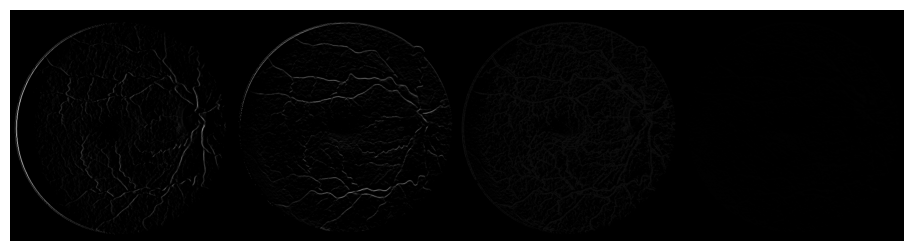

In [11]:
def Gradient_Based_features (image) :
  """
      Calculate gradient-based features from a grayscale image using
      convolution with Sobel-like kernels.

      Args:
          image (np.ndarray): A 2D grayscale image array of shape (height, width).


      Returns:
          tuple: A tuple containing four elements:
              - Gx (np.ndarray): The gradient of the image in the x-direction.
              - Gy (np.ndarray): The gradient of the image in the y-direction.
              - M (np.ndarray): The magnitude of the gradient.
              - Theta (np.ndarray): The angle of the gradient direction.
  """
  #################################################################################
  #                         YOUR CODE GOES HERE                                  #
  dx_kernel = np.array([[-1,0,1]])
  dy_kernel = np.array([[-1], [0], [1]])

  Gx = cv2.filter2D(image, cv2.CV_8U, dx_kernel)
  Gy = cv2.filter2D(image, cv2.CV_8U, dy_kernel)
  M = np.sqrt(Gx**2 + Gy**2)
  Theta = np.arctan2(Gy,Gx)

  #################################################################################
  return Gx, Gy, M, Theta
test_gradient_image=Gradient_Based_features(test_img_preprocessed)
plot_images(test_gradient_image)


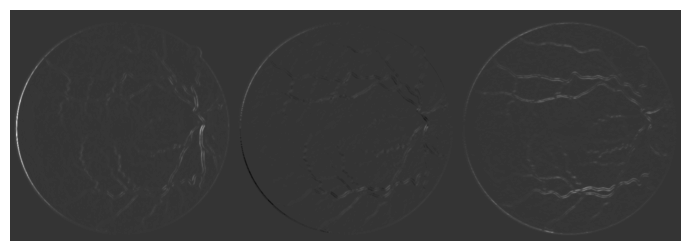

In [12]:
def Hessian_features(image) :
  """
    Calculate Hessian matrix components for a given grayscale image
    to capture second-order derivative information for edge detection.

    Args:
        image (np.ndarray): A 2D grayscale image array of shape (height, width).

    Returns:
        tuple: A tuple containing three elements:
            - Gxx (np.ndarray): The second derivative of the image with respect
              to the x-direction.
            - Gxy (np.ndarray): The mixed second derivative of the image with respect
              to both x and y directions.
            - Gyy (np.ndarray): The second derivative of the image with respect
              to the y-direction.
  """
  #################################################################################
  #                         YOUR CODE GOES HERE                                   #
  Ix = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)  # X edges
  Iy = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)  # Y edges

  Gxx = ndi.gaussian_filter(Ix ** 2, sigma=1)
  Gxy = ndi.gaussian_filter(Ix * Iy, sigma=1)
  Gyy = ndi.gaussian_filter(Iy ** 2, sigma=1)

  #################################################################################
  return Gxx, Gxy, Gyy

test_hessian_image=Hessian_features(test_img_preprocessed)
plot_images(test_hessian_image)

In [55]:
def Statistical_features(image, index):
    """
    Compute statistical features from a given grayscale image.

    Args:
        image (np.ndarray): A 2D grayscale image array of shape (height, width).
        index (tuple(np.ndarray,np.ndarray)): A tuple of two vector which contains x and y coordinates of non-zero pixels
    Returns:
        np.ndarray: A 3D array of shape (height, width, 8) containing the following
                    statistical features for each pixel:
                    - Mean
                    - Minimum
                    - Maximum
                    - Skewness
                    - Kurtosis
                    - Standard Deviation
                    - Mean Absolute Deviation
                    - Root Sum of Squared Levels
    """

    #################################################################################
    #                         YOUR CODE GOES HERE                                   #


    # Mean, Minimum, Maximum, Skewness, Kurtosis, Standard deviation,
    # Mean absolute deviation, Root sum of squared level, size = 21
    k = 10
    img = cv2.copyMakeBorder(image, k, k, k, k, cv2.BORDER_CONSTANT, None, image.mean())
    output = np.zeros((image.shape[0], image.shape[1], 8))
    X, Y = index

    # for idx in tqdm(range(len(index[0]))):
    for idx in range(len(index[0])):

            i = X[idx] + k
            j = Y[idx] + k
            sig = img[i-k:i+k+1, j-k:j+k+1].flatten()
            output[i-2*k, j-2*k, 0] = np.mean(sig) #mean
            output[i-2*k, j-2*k, 1] = sig.min() #min
            output[i-2*k, j-2*k, 2] = sig.max() #max
            output[i-2*k, j-2*k, 3] = skew(sig) #skew
            output[i-2*k, j-2*k, 4] = kurtosis(sig) #kurtosis
            output[i-2*k, j-2*k, 5] = np.std(sig) #std
            output[i-2*k, j-2*k, 6] = np.mean(np.abs(sig-np.mean(sig))) #mean absolute deviation
            output[i-2*k, j-2*k, 7] = np.sqrt(np.sum(sig**2)) #root sum of squared level

    #################################################################################
    return [stat for stat in output[:, :]]
index = np.where(test_mask != 0)
test_statistic_features=Statistical_features(test_img_preprocessed,index)
mean, min, max, Skewness, Kurtosis, std, mad, sqrt = np.transpose(test_statistic_features, (2, 0, 1))[:]
test_statistic_features=np.stack((mean[index],  min[index],  max[index],  Skewness[index],  Kurtosis[index],  std[index],  mad[index],  sqrt[index]), axis=1)
data = pd.DataFrame()
df = pd.DataFrame(test_statistic_features)
df

,0,1,2,3,4,5,6,7
0,69.235828,0.0,90.0,-2.255093,4.147442,21.166625,13.802541,234.343765
1,69.253968,0.0,90.0,-2.264973,4.222820,21.035094,13.719325,234.761581
2,69.260771,0.0,90.0,-2.261983,4.236357,20.957522,13.700639,234.767971
3,69.256236,0.0,90.0,-2.248239,4.197695,20.929102,13.718050,234.149525
4,69.192744,0.0,90.0,-2.226537,4.116711,20.938015,13.751102,232.778865
...,...,...,...,...,...,...,...,...
227681,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
227682,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
227683,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
227684,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000




1. **Setup Paths**: Defines paths for images, masks, and labels from the DRIVE dataset.
   
2. **Load File Lists**: Retrieves and sorts the filenames for images, masks, and labels from the specified directories.

3. **Initialize DataFrame**: Creates an empty DataFrame to store the extracted features from each processed image.

4. **Image Processing Loop**: Iterates over the first 20 images:
   - Reads each image and its corresponding mask and label.
   - Reshapes the mask and label arrays to standard dimensions.
   - Converts label values from 255 to 1 for binary representation.
   - Applies preprocessing to the image using the `PreProcess` function.

5. **Feature Extraction**: Extracts various features from the preprocessed image:
   - Edge features using the `Edge_Algorithm_features` function.
   - Morphological features using the `Morphological_features` function.
   - Statistical features (mean, min, max, skewness, kurtosis, standard deviation, mean absolute deviation, and root sum of squares) using the `Statistical_features` function.
   - Gradient-based features (Gx, Gy, magnitude, and angle) using the `Gradient_Based_features` function.
   - Hessian features using the `Hessian_features` function.

6. **Feature Compilation**: Stacks the extracted features along with the corresponding label and creates a DataFrame from the features.

7. **Data Storage**: Concatenates the newly created DataFrame with the main DataFrame to accumulate all extracted features.

This step prepares the data for  model training.



In [14]:

train_image_path = 'DRIVE/Training/images/'
train_mask_path = 'DRIVE/Training/mask/'
train_label_path = 'DRIVE/Training/1st_manual/'

test_image_path = 'DRIVE/Test/images/'
test_mask_path = 'DRIVE/Test/mask/'
test_label_path = 'DRIVE/Test/1st_manual/'
def extract_features(image_path, mask_path, label_path):

        images = [f for f in listdir(image_path) if isfile(join(image_path, f))]
        images.sort()
        masks = [f for f in listdir(mask_path) if isfile(join(mask_path, f))]
        masks.sort()
        labels = [f for f in listdir(label_path) if isfile(join(label_path, f))]
        labels.sort()
        data = pd.DataFrame()
        for i in tqdm(range(len(images))) :
            image = cv2.imread(join(image_path, images[i]))
            mask = np.array(imageio.mimread(join(mask_path, masks[i]))).reshape(584, 565)
            label = np.array(imageio.mimread(join(label_path, labels[i]))).reshape(584, 565)
            label[np.where(label == 255)] = 1
            index = np.where(mask != 0)
            image = PreProcess(image[:, :, 1], mask,False)

            ################# feature extraction######################################

            edges = Edge_Algorithm_features(image)
            (tophat, bothat, tophat2, bothat2) = Morphological_features(image)
            mean, min, max, Skewness, Kurtosis, std, mad, sqrt = np.transpose(Statistical_features(image, index), (2, 0, 1))[:]
            (Gx, Gy, M, Theta) = Gradient_Based_features(image)
            (Gxx, Gxy, Gyy) = Hessian_features(image)
            features = np.stack((edges[index], tophat[index], bothat[index], Gx[index], Gy[index], tophat2[index], bothat2[index],
                                mean[index],  min[index],  max[index],  Skewness[index],  Kurtosis[index],  std[index],  mad[index],  sqrt[index],
                                M[index], Theta[index], Gxx[index], Gxy[index], Gyy[index], label[index]), axis=1)

            df = pd.DataFrame(features)
            data = pd.concat([data, df])
        return data



df_train = extract_features(train_image_path, train_mask_path, train_label_path)
df_test = extract_features(test_image_path, test_mask_path, test_label_path)


100%|██████████| 20/20 [1:46:37<00:00, 319.85s/it]


In [15]:
df_train.to_csv("train.csv")
df_test.to_csv("test.csv")



df_train=pd.read_csv("train.csv")
df_test=pd.read_csv("test.csv")

In [ ]:

# df_train.to_csv("train.csv", index=False)

# files.download("train.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [16]:
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/My Drive/test.csv'

df_test.to_csv(file_path, index=False)

Mounted at /content/drive


In [17]:
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/My Drive/train.csv'

df_train = pd.read_csv(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Training Phase (18 pts)

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler

- **Note**: Due to the significant differences in the scale of the extracted features, the values should normalize before training the neural network.


In [19]:
sc = StandardScaler()

shuffled = df_train.sample(frac=1)
X_train = sc.fit_transform(shuffled.iloc[:, 1:21])
Y_train = shuffled.iloc[:, -1].astype(int).to_numpy()


X_test = sc.fit_transform(df_test.iloc[:, 1:21])
Y_test = df_test.iloc[:, -1].astype(int).to_numpy()

- **Note**: Since the number of foreground pixels is much smaller than the background pixels, a weighted binary cross-entropy loss is used, with a higher weight assigned to errors in detecting blood vessels.(9pt)

In [20]:

class MyDataset(Dataset):

  def __init__(self,X, Y):

    self.x_train=torch.tensor(X,dtype=torch.float32)
    self.y_train=torch.tensor(Y,dtype=torch.float32)

  def __len__(self):
    return len(self.y_train)

  def __getitem__(self,idx):
    return self.x_train[idx],self.y_train[idx]


class Classifier(nn.Module):
   def __init__(self):
      super(Classifier, self).__init__()
      self.fc1 = nn.Linear(20, 32)
      self.fc2 = nn.Linear(32, 32)
      self.fc4 = nn.Linear(32,16)
      self.fc3 = nn.Linear(16,1)
   def forward(self, x):
      x = torch.tanh(self.fc1(x))
      x = torch.tanh(self.fc2(x))
      x = torch.tanh(self.fc4(x))
      return torch.sigmoid(self.fc3(x))

class weighted_binary_cross_entropy(nn.Module):
    def __init__(self):
      super(weighted_binary_cross_entropy, self).__init__()

    def forward(self, output, target, weights=None):
        output = torch.clamp(output,min=1e-8,max=1-1e-8)

        if weights is not None:
            assert len(weights) == 2
            #################################################################################
            #                         YOUR CODE GOES HERE                                   #
            loss = weights[0] * target * torch.log(output) + weights[1] * (1 - target) * torch.log(1 - output)
        else:
            loss = target * torch.log(output) + (1 - target) * torch.log(1 - output)

        return torch.neg(torch.mean(loss))

In [21]:
#####################################
###### DO NOT CHANGE THIS CELL ######
#####################################

N_EPOCHS = 20
BATCH_SIZE = 128
LR = 1e-2
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_loader = DataLoader(MyDataset(X_train, Y_train), batch_size=BATCH_SIZE, shuffle=False)
model = Classifier().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
criterion = weighted_binary_cross_entropy()

- After generating the probability of each pixel being part of a blood vessel. A fixed threshold of `0.4` should choose to binarize these values.

In [22]:
# training loop
def train_model(model, train_dataloader, n_epochs, optimizer, criterion, device):
    model.train()
    train_losses = []
    train_accuracies = []
    for epoch in tqdm(range(n_epochs)):
    #################################################################################
    #                         YOUR CODE GOES HERE                                   #

        epoch_loss = 0
        correct=0
        total=0
        for data, target in train_dataloader:

            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            output = output.reshape(target.shape)
            loss = criterion(output, target, [1, 1.2])
            loss.backward()
            optimizer.step()

            predicted = output >= 0.4
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
            epoch_loss += loss.item()

        accu=100.0*correct/total
        train_loss = epoch_loss / len(train_loader)
        train_accuracies.append(accu)
        train_losses.append(train_loss)

    #################################################################################
        print('Epoch: {}  Train Loss: {:.4f}  Accuracy: {:.3f}'.format(epoch+1, train_loss, accu))

    return model, train_losses, train_accuracies


In [23]:
trained_model, train_losses, train_accuracies = train_model(model, train_loader, N_EPOCHS, optimizer, criterion, DEVICE)

  5%|▌         | 1/20 [01:40<31:53, 100.71s/it]

Epoch: 1  Train Loss: 0.1999  Accuracy: 93.181


 10%|█         | 2/20 [03:20<30:02, 100.15s/it]

Epoch: 2  Train Loss: 0.1906  Accuracy: 93.498


 15%|█▌        | 3/20 [05:14<30:13, 106.70s/it]

Epoch: 3  Train Loss: 0.1888  Accuracy: 93.551


 20%|██        | 4/20 [07:07<29:02, 108.88s/it]

Epoch: 4  Train Loss: 0.1877  Accuracy: 93.582


 25%|██▌       | 5/20 [08:51<26:50, 107.35s/it]

Epoch: 5  Train Loss: 0.1869  Accuracy: 93.606


 30%|███       | 6/20 [10:33<24:37, 105.56s/it]

Epoch: 6  Train Loss: 0.1863  Accuracy: 93.626


 35%|███▌      | 7/20 [12:12<22:22, 103.29s/it]

Epoch: 7  Train Loss: 0.1857  Accuracy: 93.645


 40%|████      | 8/20 [13:49<20:13, 101.13s/it]

Epoch: 8  Train Loss: 0.1852  Accuracy: 93.657


 45%|████▌     | 9/20 [15:31<18:35, 101.45s/it]

Epoch: 9  Train Loss: 0.1847  Accuracy: 93.669


 50%|█████     | 10/20 [17:10<16:46, 100.66s/it]

Epoch: 10  Train Loss: 0.1844  Accuracy: 93.678


 55%|█████▌    | 11/20 [18:49<15:01, 100.18s/it]

Epoch: 11  Train Loss: 0.1841  Accuracy: 93.686


 60%|██████    | 12/20 [20:27<13:15, 99.49s/it] 

Epoch: 12  Train Loss: 0.1838  Accuracy: 93.692


 65%|██████▌   | 13/20 [22:03<11:29, 98.52s/it]

Epoch: 13  Train Loss: 0.1836  Accuracy: 93.697


 70%|███████   | 14/20 [23:40<09:48, 98.15s/it]

Epoch: 14  Train Loss: 0.1833  Accuracy: 93.704


 75%|███████▌  | 15/20 [25:19<08:12, 98.50s/it]

Epoch: 15  Train Loss: 0.1831  Accuracy: 93.708


 80%|████████  | 16/20 [26:56<06:31, 97.79s/it]

Epoch: 16  Train Loss: 0.1829  Accuracy: 93.713


 85%|████████▌ | 17/20 [28:34<04:53, 97.90s/it]

Epoch: 17  Train Loss: 0.1828  Accuracy: 93.716


 90%|█████████ | 18/20 [30:12<03:16, 98.06s/it]

Epoch: 18  Train Loss: 0.1826  Accuracy: 93.720


 95%|█████████▌| 19/20 [31:50<01:37, 97.94s/it]

Epoch: 19  Train Loss: 0.1824  Accuracy: 93.723


100%|██████████| 20/20 [33:27<00:00, 100.35s/it]

Epoch: 20  Train Loss: 0.1823  Accuracy: 93.726


--------------
In order to `evaluate` the method, three metrics will be used: accuracy, specificity, and sensitivity, each of which is defined as follows:

First, we define the parameters TP, TN, FP, and FN, which will be used to calculate the mentioned metrics.

`TP`: The number of pixels that are part of the vessel, and the method also correctly identifies them as vessels.

`TN`: The number of pixels that belong to the background, and the method also correctly identifies them as background.

`FP`: The number of pixels that belong to the background, but the method incorrectly identifies them as vessels.

`FN`: The number of pixels that are part of the vessel, but the method incorrectly identifies them as background.

With these definitions in place, the three metrics are defined as follows:


$
\text{Sensitivity} = \frac{TP}{TP + FN}
$


$
\text{Specificity} = \frac{TN}{TN + FP}
$


$
\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
$


In [24]:
def evaluation(image, label, mask) :

  TP = TN =  FP = FN = 0
  row, col = image.shape
  for i in range(row):
    for j in range(col):

     # if mask[i, j] != 0:
        p = image[i, j]
        l = label[i, j]
        if p != 0 and l != 0:
          TP +=1
        elif p != 0 and l == 0 :
          FP +=1
        elif p == 0 and l == 0 :
          TN +=1
        elif p == 0 and l != 0 :
          FN +=1

  Sn = TP/(TP + FN)
  Sp = TN/(TN + FP)
  Acc = (TP + TN)/(TP + TN + FP + FN)

  return Sn, Sp, Acc

-----
- `Note`: you must reach at least `70%` sensitivity, `90%` specificity, and `90%` accuracy. (3 pts)


In [25]:
test_image_path = 'DRIVE/Test/images/'
test_mask_path = 'DRIVE/Test/mask/'
test_label_path = 'DRIVE/Test/1st_manual/'

images = [f for f in listdir(test_image_path) if isfile(join(test_image_path, f))]
images.sort()

masks = [f for f in listdir(test_mask_path) if isfile(join(test_mask_path, f))]
masks.sort()

labels = [f for f in listdir(test_label_path) if isfile(join(test_label_path, f))]
labels.sort()




sum = 0
cnt = 0
sn = sp = acc = 0

for i in tqdm(range(len(images))) :
  image = cv2.imread(join(test_image_path, images[i]))
  mask = np.array(imageio.mimread(join(test_mask_path, masks[i]))).reshape(584, 565)
  label = np.array(imageio.mimread(join(test_label_path, labels[i]))).reshape(584, 565)
  label[np.where(label == 255)] = 1
  index = np.where(mask != 0)
  cnt = index[0].shape[0]

  temp = np.zeros((584, 565))
  X = torch.from_numpy(X_test[sum:sum+cnt, :]).to(DEVICE)
  Y = Y_test[sum:sum+cnt]

  out = model(X.float()).reshape(Y.shape) >= 0.4

  x, y = index
  for idx in range(cnt,) :
    m = x[idx]
    n = y[idx]

    if out[idx] == 1:
      temp[m, n] = 255

  sum += cnt

  ########## for removing borders of mask ##############
  border = LOG_Edge_Detection(mask)
  kernel = np.ones((4, 4), np.uint8)
  border = cv2.dilate(border.astype('uint8'), kernel, iterations=1)
  idx = np.where(border != 0)
  temp[idx] = 0

  SN, SP, ACC = evaluation(temp, label, mask)

  sn += SN
  sp += SP
  acc += ACC


print(sn/len(images))
print(sp/len(images))
print(acc/len(images))

100%|██████████| 20/20 [02:08<00:00,  6.42s/it]

0.6750651510134937
0.9857474534509624
0.9584032913080375


- Show two sample images along with their ground truth and the model output at the end. (6 pts)

  0%|          | 0/2 [00:00<?, ?it/s]

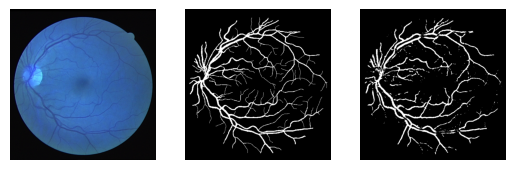

 50%|█████     | 1/2 [00:04<00:04,  4.11s/it]

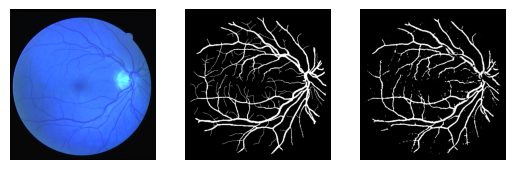

100%|██████████| 2/2 [00:08<00:00,  4.23s/it]


In [54]:
#################################################################################
#                         YOUR CODE GOES HERE                                   #

sum = 0
cnt = 0
sn = sp = acc = 0
for i in tqdm(range(2)) :
  image = cv2.imread(join(test_image_path, images[i]))
  mask = np.array(imageio.mimread(join(test_mask_path, masks[i]))).reshape(584, 565)
  label = np.array(imageio.mimread(join(test_label_path, labels[i]))).reshape(584, 565)
  label[np.where(label == 255)] = 1
  index = np.where(mask != 0)
  cnt = index[0].shape[0]

  temp = np.zeros((584, 565))
  X = torch.from_numpy(X_test[sum:sum+cnt, :]).to(DEVICE)
  Y = Y_test[sum:sum+cnt]

  out = model(X.float()).reshape(Y.shape) >= 0.4

  x, y = index
  for idx in range(cnt,) :
    m = x[idx]
    n = y[idx]

    if out[idx] == 1:
      temp[m, n] = 255

  sum += cnt

  plt.subplot(1,3,1)
  plt.imshow(image,cmap='gray')
  plt.axis('off')
  plt.subplot(1,3,2)
  plt.imshow(label,cmap='gray')
  plt.axis('off')
  plt.xlabel('Label')
  plt.subplot(1,3,3)
  plt.imshow(temp,cmap='gray')
  plt.axis('off')
  plt.xlabel('Predicted')
  plt.show()

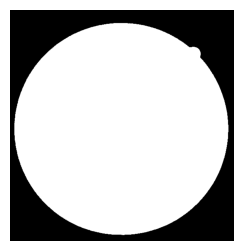

In [45]:
plot_images([mask])